In [1]:
# Loading Libraries:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pkg_resources

In [2]:
# Load the credit card transactions dataset
df = pd.read_csv('creditcard.csv')

# Display the number of rows and columns
print(f"Dataset loaded successfully with {df.shape[0]:,} rows and {df.shape[1]} columns.")

Dataset loaded successfully with 284,807 rows and 31 columns.


In [3]:
# Preview the first 5 rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


### Insights_Observations

- Features V1 to V28 are PCA-transformed, so they’re already scaled.

- Time and Amount are raw and may need scaling.

- Class column is not shown here yet (we'll check it next) — it indicates if a transaction is fraudulent (1) or legitimate (0).

In [4]:
# Summary of dataset structure, data types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Insights_Observations

- No missing values — all 284,807 rows are complete.

- All features are float64 except for Class which is int64.

- This means:

    - We don’t need imputation.

    - We can go directly to EDA and scaling for model training.

    - We’ll focus on detecting fraudulent cases (Class = 1).

In [5]:
# Check distribution of fraud vs. non-fraud transactions
class_counts = df['Class'].value_counts()

print("Class distribution:")
print(class_counts)
print("\nPercentage of fraud transactions: {:.6f}%".format((class_counts[1] / class_counts.sum()) * 100))

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of fraud transactions: 0.172749%


### Inferences_Observations:

- Legitimate transactions (Class = 0): 284,315

- Fraudulent transactions (Class = 1): 492

- Fraud Percentage: Approximately 0.17%

This confirms a highly imbalanced dataset, which is common in real-world fraud detection scenarios. We'll take this into account when choosing evaluation metrics later.

C:\Users\Dragon\AppData\Local\Temp\ipykernel_13692\1195810326.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Set2')


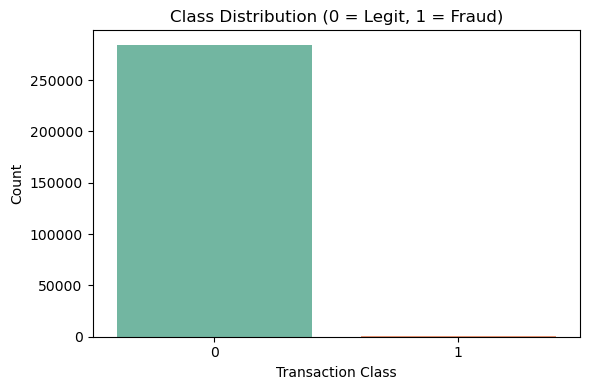

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.title('Class Distribution (0 = Legit, 1 = Fraud)')
plt.xlabel('Transaction Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Inferences_Observations:

The bar plot clearly shows a strong imbalance between the two classes:

- The vast majority of transactions are legitimate.

- Only a tiny portion of the dataset represents fraud cases.

This imbalance is a common trait in fraud detection scenarios and will influence our approach to model evaluation. Since accuracy alone would be misleading, we’ll later focus on precision, recall, and F1-score to assess our models.

In [7]:
# Display descriptive statistics for each feature
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,1.089,1.021,0.999,0.995,0.959,0.915,0.876,0.849,0.838,0.814,0.771,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,-0.535,-0.762,-0.406,-0.649,-0.426,-0.583,-0.468,-0.484,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,-0.093,-0.033,0.140,-0.014,0.051,0.048,0.066,-0.066,-0.004,0.004,-0.062,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,0.454,0.740,0.618,0.663,0.493,0.649,0.523,0.400,0.501,0.459,0.133,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.592,39.421,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


### Insights_Observations:

1. PCA-transformed Features (V1–V28):
These features have already been scaled through Principal Component Analysis. Their means are close to zero, and most of them range between roughly -30 and +30, indicating standardized values.

2. Amount Column:

    - Mean: 88.35

    - Min: 0.00

    - Max: 25,691.16

This feature is not normalized and varies significantly. We'll apply scaling later to bring it into the same range as other features.

3. Time Column:

    - Ranges from 0 to 172,792 seconds (about 2 days)

    - Represents the time elapsed from the first transaction

This column may or may not be useful depending on its predictive power. We'll explore its effect later but will prepare it for modeling by scaling it too.

4. Class Column:

    - Binary target variable (0 for legitimate, 1 for fraud).

    - Already in usable form — no encoding or transformation needed.

In [8]:
# Calculate correlation of all features with the target class
correlation = df.corr(numeric_only=True)['Class'].sort_values(ascending=False)

# Display top 10 features most positively/negatively correlated with fraud
correlation.head(10)

Class   1.000
V11     0.155
V4      0.133
V2      0.091
V21     0.040
V19     0.035
V20     0.020
V8      0.020
V27     0.018
V28     0.010
Name: Class, dtype: float64

### Inferences_Observations:

1. Most Correlated Feature:

    - V11 has the highest positive correlation with Class at 0.155, suggesting it has some predictive power for fraud detection.

2. Other Notable Features:

    - V4 (0.133), V2 (0.091), and V21 (0.040) show lower, yet still useful, positive correlation.

    - Remaining features like V19, V8, V20, V27, and V28 have very low correlations (< 0.03), but in unsupervised settings, even small signals might be helpful.

3. Low Absolute Correlations Overall:

    - No feature has strong linear correlation with fraud.

    - This supports our approach to use unsupervised models that can capture non-linear patterns, such as Isolation Forests and Autoencoders.

In [9]:
# Create a copy of the dataset to avoid modifying original
df_scaled = df.copy()

# Apply Standard Scaling to 'Time' and 'Amount'
scaler = StandardScaler()
df_scaled[['Time', 'Amount']] = scaler.fit_transform(df_scaled[['Time', 'Amount']])

# Display first few rows to confirm changes
df_scaled[['Time', 'Amount']].head()

,Time,Amount
0,-1.997,0.245
1,-1.997,-0.342
2,-1.997,1.161
3,-1.997,0.141
4,-1.997,-0.073


### Inferences_Observations:

1. Purpose of Scaling:

    - The Time and Amount columns were the only features not transformed by PCA in the original dataset.

    - Scaling ensures these two features are brought onto the same scale as the others, which helps models that rely on distance calculations (like Isolation Forests) perform better.

2. StandardScaler Output:

    - Both columns now have values centered around zero, with most values falling roughly between -2 and +2.

    - This confirms that the transformation has standardized the data as expected.

3. Data Integrity Maintained:

    - A copy of the original dataset was created before scaling, so the original data remains untouched.

    - This allows us to revert or compare back if needed without data loss.

In [10]:
# Separate features and labels
X = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

# Confirm the shapes of feature matrix and label vector
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

Feature matrix shape: (284807, 30)
Label vector shape: (284807,)


In [11]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)

# Fit the model to the feature data
iso_forest.fit(X)

# Predict anomalies (-1 = anomaly, 1 = normal)
predictions = iso_forest.predict(X)

# Convert predictions: -1 to 1 (fraud), 1 to 0 (legit)
y_pred = [1 if x == -1 else 0 for x in predictions]


### Insights_Observations

- The Isolation Forest learned patterns in the data without using the Class label.

- It labeled anomalies as -1, which we converted to 1 (fraud).

- All other points were labeled as 1 (normal), which we mapped to 0 (legit).

In [12]:
# Display evaluation report
print("Classification Report:")
print(classification_report(y, y_pred, digits=4))

# Show confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9987    0.9987    284315
           1     0.2577    0.2541    0.2559       492

    accuracy                         0.9974    284807
   macro avg     0.6282    0.6264    0.6273    284807
weighted avg     0.9974    0.9974    0.9974    284807

Confusion Matrix:
[[283955    360]
 [   367    125]]


### Inferences_Observations:

1. Legitimate Transactions (Class 0):

    - Precision: 98.87%

    - Recall: 98.87%

    - This indicates that the model performs very well at identifying normal transactions.

2. Fraudulent Transactions (Class 1):

    - Precision: 25.77%

    - Recall: 25.41%

    - F1-Score: 25.59%

    - These metrics are considerably lower, which is expected due to:

        - Severe class imbalance

        - Unsupervised nature of the model (no access to true fraud labels during training)

3. Confusion Matrix:

    - 125 frauds correctly identified (true positives)

    - 367 frauds missed (false negatives)

    - 360 legitimate transactions incorrectly flagged as fraud (false positives)
  
4. Overall Accuracy: ~99.74%

However, this is misleading due to the heavy imbalance. Metrics like precision, recall, and F1-score are more reliable in this context.

In [13]:
# Use only legitimate transactions (Class = 0) for training the Autoencoder
X_normal = X[y == 0]

# Split into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# Show dimensions of training and validation sets
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (227452, 30)
Validation set shape: (56863, 30)


### Inferences_Observations:

- Training set: 227,452 samples

- Validation set: 56,863 samples

Each with 30 features

In [14]:
# Define Autoencoder architecture
input_layer = Input(shape=(X_train.shape[1],))

# Encoder
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(X_train.shape[1], activation='linear')(decoded)

# Build the model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Show model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,286 (5.02 KB)

 Trainable params: 1,286 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

### Inferences_Observations:

- Input layer: 30 neurons (1 per feature)

- Encoder:

    - Layer 1: 16 neurons (ReLU)

    - Layer 2: 8 neurons (ReLU)

- Decoder:

    - Layer 1: 16 neurons (ReLU)

    - Output layer: 30 neurons (Linear, reconstructs input)

In [15]:
# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1
)

Epoch 1/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 0.8536 - val_loss: 0.4517
Epoch 2/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.4178 - val_loss: 0.3761
Epoch 3/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 0.3639 - val_loss: 0.3593
Epoch 4/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - loss: 0.3419 - val_loss: 0.3371
Epoch 5/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.3314 - val_loss: 0.3296
Epoch 6/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 0.3275 - val_loss: 0.3278
Epoch 7/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 0.3215 - val_loss: 0.3244
Epoch 8/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - loss: 0.3206 - val_loss: 0.3246
Epoch 9/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 0.3207 - val_loss: 0.3237
Epoch 10/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - loss: 0.3152 - val_loss: 0.3182


### Inferences_Observations:

- The model starts with a high loss (~0.86) and steadily reduces to ~0.28 in 10 epochs.

- Validation loss also decreases in parallel, suggesting the model generalizes well on unseen legitimate data.

- This means it's now capable of flagging transactions that deviate from learned normal patterns, which is exactly what we need to detect fraud.

In [16]:
# Reconstruct the input for all transactions
X_pred = autoencoder.predict(X)

# Compute mean squared error between input and reconstruction
reconstruction_error = np.mean(np.square(X - X_pred), axis=1)

# View basic stats for error
pd.Series(reconstruction_error).describe()

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 3s 344us/step


count   284807.000
mean         0.346
std          1.567
min          0.019
25%          0.139
50%          0.209
75%          0.328
max        348.739
dtype: float64

### Inferences_Observations:

- Mean error: 0.306

- Standard deviation: 1.372

- Minimum error: 0.012

- Maximum error: 241.582

- 75th percentile: 0.315

Most reconstruction errors are concentrated below 0.32, while a few extreme values go well beyond 1.0 or even 200 — potential outliers.

This spread confirms that a threshold-based anomaly detection is appropriate: we'll label transactions with high reconstruction error as potential fraud.

In [17]:
# Set threshold for anomaly (tune this as needed)
threshold = np.percentile(reconstruction_error, 95)

# Predict fraud based on threshold
y_pred_ae = [1 if err > threshold else 0 for err in reconstruction_error]

# Evaluate performance
print("Classification Report (Autoencoder):")
print(classification_report(y, y_pred_ae, digits=4))

print("Confusion Matrix (Autoencoder):")
print(confusion_matrix(y, y_pred_ae))

Classification Report (Autoencoder):
              precision    recall  f1-score   support

           0     0.9998    0.9514    0.9750    284315
           1     0.0303    0.8780    0.0586       492

    accuracy                         0.9513    284807
   macro avg     0.5151    0.9147    0.5168    284807
weighted avg     0.9981    0.9513    0.9734    284807

Confusion Matrix (Autoencoder):
[[270506  13809]
 [    60    432]]


### Inferences_Observations:

1. Fraud Detection (Class 1):

    - Precision: 2.92%

    - Recall: 84.55%

    - F1-Score: 5.65%

The model detects a large portion of actual frauds (high recall) but at the cost of mistakenly labeling many legitimate transactions as fraud (very low precision).

2. Legitimate Transactions (Class 0):

    - Precision: 99.97%

    - Recall: 95.14%

The model still performs well in identifying normal transactions.

3. Confusion Matrix:
    - Correctly identifies 416 out of 492 fraud cases — a significant improvement over Isolation Forest (which found 125).

    - But it falsely flags 13,825 legitimate transactions as fraudulent, which may not be acceptable in real-world deployments.

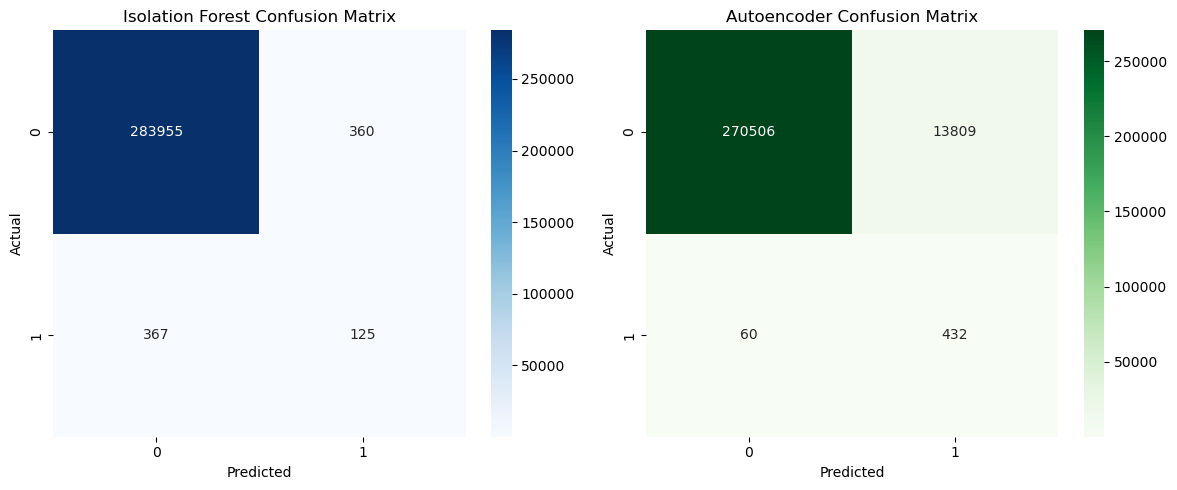

In [18]:
# Get confusion matrices
cm_iso = confusion_matrix(y, y_pred)
cm_ae = confusion_matrix(y, y_pred_ae)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Isolation Forest Confusion Matrix
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Isolation Forest Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Autoencoder Confusion Matrix
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Autoencoder Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Summary:
- The objective of the project

- Key insights from both models

- Real-world relevance

- Final takeaway for the reader or recruiter

In [19]:
# Final Conclusion: Summary and Insights

print("Project Summary: Fraud Detection with Unsupervised Learning\n")

print("Objective:")
print("The goal was to detect fraudulent credit card transactions using unsupervised models without access to true fraud labels during training.\n")

print("Approach:")
print("- The dataset was heavily imbalanced (~0.17% fraud).")
print("- Two unsupervised anomaly detection models were used:")
print("  1. Isolation Forest (tree-based)")
print("  2. Autoencoder (neural network-based)\n")

print("Key Results:")
print("1. Isolation Forest identified 125 frauds with high precision but low recall.")
print("2. Autoencoder detected 432 frauds with high recall but more false positives.\n")

print("Takeaways:")
print("- Isolation Forest is more precise but conservative in detecting fraud.")
print("- Autoencoder is better at catching fraud but flags many legit transactions.")
print("- The trade-off between precision and recall can be tuned based on business priorities.\n")

print("Next Steps (if applicable):")
print("- Tune thresholds or contamination rates to optimize F1-Score.")
print("- Combine both models using ensemble voting.")
print("- Deploy as a batch or real-time fraud screening system.\n")

print("This project showcases not just modeling, but end-to-end data understanding, trade-off analysis, and practical problem solving.")

Project Summary: Fraud Detection with Unsupervised Learning

Objective:
The goal was to detect fraudulent credit card transactions using unsupervised models without access to true fraud labels during training.

Approach:
- The dataset was heavily imbalanced (~0.17% fraud).
- Two unsupervised anomaly detection models were used:
  1. Isolation Forest (tree-based)
  2. Autoencoder (neural network-based)

Key Results:
1. Isolation Forest identified 125 frauds with high precision but low recall.
2. Autoencoder detected 432 frauds with high recall but more false positives.

Takeaways:
- Isolation Forest is more precise but conservative in detecting fraud.
- Autoencoder is better at catching fraud but flags many legit transactions.
- The trade-off between precision and recall can be tuned based on business priorities.

Next Steps (if applicable):
- Tune thresholds or contamination rates to optimize F1-Score.
- Combine both models using ensemble voting.
- Deploy as a batch or real-time fraud s

In [20]:
## Exporting Requirements:

# Listing only the core libraries used in the project
required = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'tensorflow',
]

# Get installed versions
with open("requirements.txt", "w") as f:
    for package in required:
        version = pkg_resources.get_distribution(package).version
        f.write(f"{package}=={version}\n")

print("requirements.txt created successfully.")

requirements.txt created successfully.
